#### Main Steps
1. Frame the problem.
2. Get the data.
3. Explore the data.
4. Prepare the data to Machine Learning algorithms.
5. Explore different models.
7. Solution.
8. Further exploration.

#### 1. Frame the problem

A company producing fiber optic sensors decided to implement the concept of Industry 4.0 in one of their production processes. They are going to implement the AI techniques to automate verification of produced sensors. 
Currently, after the production of the sensor, its characteristics should be verified each time in three reference substances in order to configure:
- Air
- Water
- Isopropanol

After the procedure in the laboratory they collected three spectroscopic signals. Unfortunately, such procedures are extremely time consuming and require large human resources. Therefore they are planning to implement AI algorithms in order to predict characteristics (or any other parameters – you can propose something) of a working sensor in water and isopropanol based on measured characteristics in air. It will enable to reduce validation process only to measurements in the air, but other characteristics will be collected based on the proposed model.

#### 2. Get the data

Data set it is a collection of measurements based on 10 sensors . Each sensor was measured three times that you can find in three separated files (e.g. sensor01_air.txt, sensor01_water.txt, sensor01_izopropanol.txt). Each file contains two-dimensional signal (signal wavelength, signal amplitude).

In [98]:
# Libraries for data analysis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Libraries for machine learning

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
import pickle

In [3]:
data_path = r"C:\Users\26609\SDA_task\Dataset"
pd.options.display.float_format = '{:12.5e}'.format

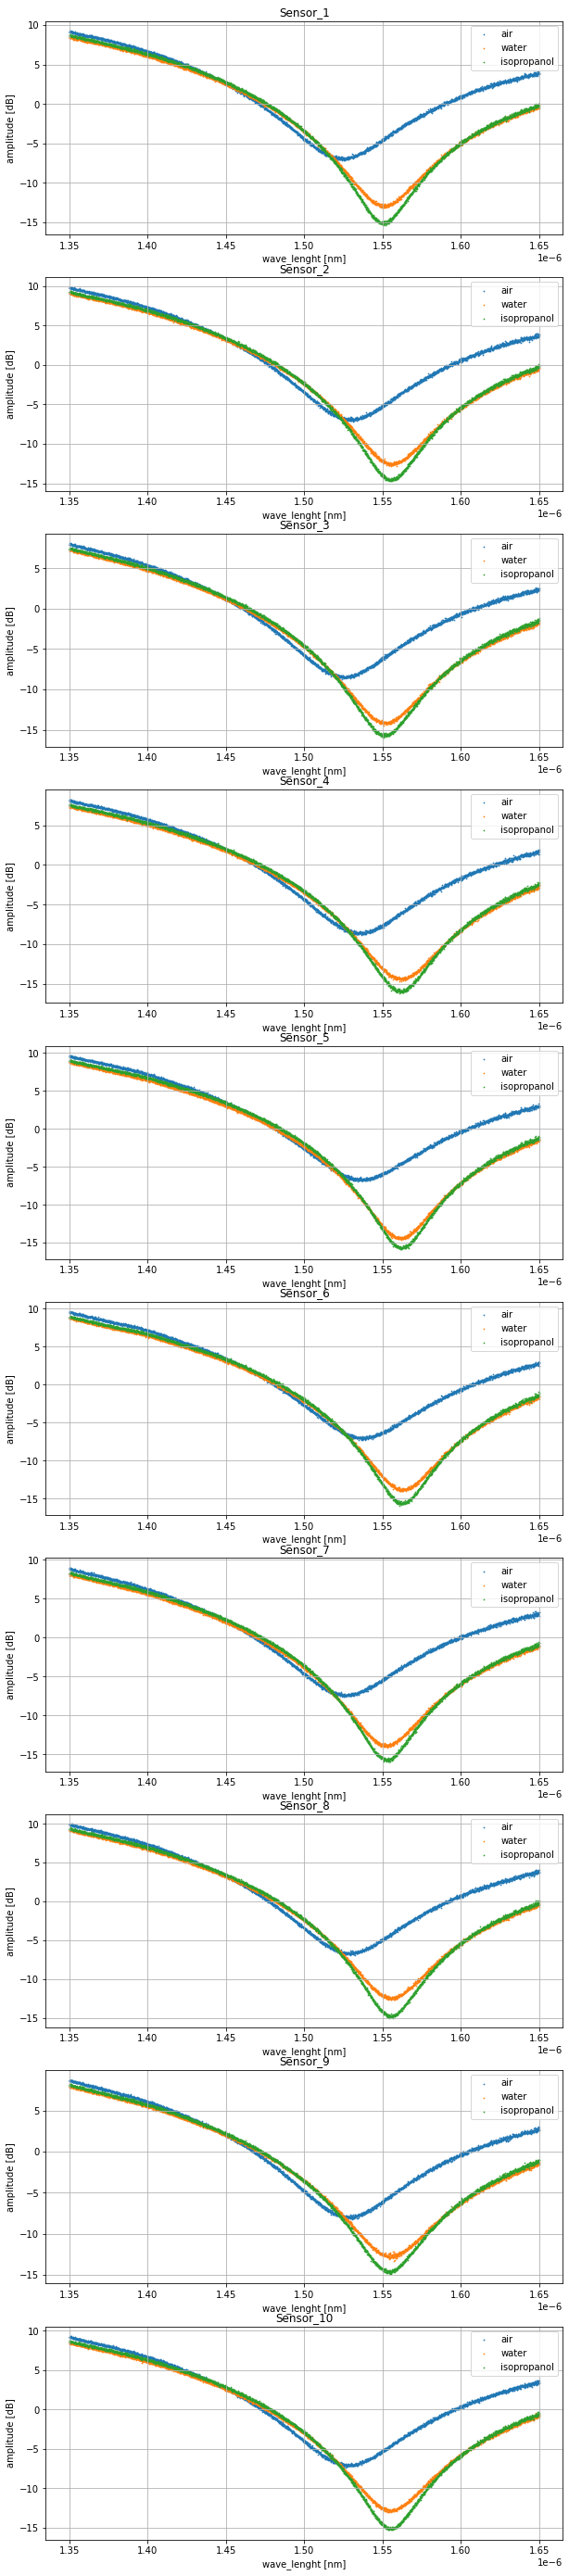

In [8]:
figure, axes = plt.subplots(10, figsize=(10, 50))

for i, fig in enumerate(axes):
    a = f"{i + 1 :02d}"
    air = pd.read_csv(fr"{data_path}\sesion_{a}_20\sensor{a}_air.txt", header=None)
    water = pd.read_csv(fr"{data_path}\sesion_{a}_20\sensor{a}_water.txt", header=None)
    izop = pd.read_csv(fr"{data_path}\sesion_{a}_20\sensor{a}_izopropanol.txt", header=None)
    fig.scatter(air[0], air[1], label="air", s=0.5)
    fig.scatter(water[0], water[1], label="water", s=0.5)
    fig.scatter(izop[0], izop[1], label="isopropanol", s=0.5)
    fig.set_title(f"Sensor_{i + 1}")
    fig.set_xlabel("wave_lenght [nm]")
    fig.set_ylabel("amplitude [dB]")
    fig.grid()
    fig.legend()

As we can see, each of the sensors draws a similar curve, which probably means that each of them is working properly. Consequently, we can treat the set of sensors as one and create a single dataset.

In [10]:
pd.options.display.float_format = '{:12.5e}'.format

def colect_data(data_path: str, sub:str) -> list:
    sensors = []
    sensor_list = os.listdir(data_path)
    
    for idx in range(1, len(sensor_list) + 1):
        path = f"{data_path}/sesion_{idx :02d}_20"
        air_list = os.listdir(path)
        for file in air_list:
            if sub in file:
                sensors_data = pd.read_csv(f"{path}/{file}", sep=",", header=None)
                sensors.append(sensors_data)
                
                
                
    return sensors

In [11]:
col_names = ["wave length", "amplitude"]

air_data = colect_data(data_path, "air")
df_air = pd.concat(air_data)
df_air.columns = col_names

water_data = colect_data(data_path, "water")
df_water = pd.concat(water_data)
df_water.columns = col_names

izo_data = colect_data(data_path, "izopropanol")
df_izo = pd.concat(izo_data)
df_izo.columns = col_names

In [17]:
df_air.sample(5)

,wave length,amplitude
835,1.43350e-06,4.14120e+00
1620,1.51200e-06,-6.83930e+00
209,1.37090e-06,7.61380e+00
1269,1.47690e-06,-8.38730e-01
965,1.44650e-06,3.10740e+00


In [18]:
df_water.sample(5)

,wave length,amplitude
62,1.35620e-06,8.27730e+00
657,1.41570e-06,5.08790e+00
1777,1.52770e-06,-8.76970e+00
1741,1.52410e-06,-8.49200e+00
1302,1.48020e-06,-6.51360e-01


In [19]:
df_izo.sample(5)

,wave length,amplitude
63,1.35630e-06,8.75640e+00
2676,1.61760e-06,-2.81910e+00
2215,1.57150e-06,-1.15400e+01
756,1.42560e-06,4.18220e+00
2399,1.58990e-06,-9.14450e+00


In [20]:
df_izo.shape, df_water.shape, df_air.shape

((30010, 2), (30010, 2), (30010, 2))

Each set contains the same number of elements, our data is balanced. It seems that we have correctly loaded all the data, the 'wave length' column appears in each set. We will not duplicate it.

In [22]:
data_frame = df_air.merge(df_water, on='wave length')
data_frame = data_frame.merge(df_izo, on="wave length")
data_frame.columns = ["wave_length", "amplitude_air", "amplitude_water", "amplitude_isopropanol"]

In [23]:
df = data_frame.copy() # Copy our data before further analysis

#### 3. Explore the data

In [24]:
df.head()

,wave_length,amplitude_air,amplitude_water,amplitude_isopropanol
0,1.35000e-06,9.17920e+00,8.35700e+00,8.55510e+00
1,1.35000e-06,9.17920e+00,8.35700e+00,9.25440e+00
2,1.35000e-06,9.17920e+00,8.35700e+00,7.34320e+00
3,1.35000e-06,9.17920e+00,8.35700e+00,7.49540e+00
4,1.35000e-06,9.17920e+00,8.35700e+00,8.97390e+00


In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wave_length,3.00100e+06,1.50000e-06,8.66314e-08,1.35000e-06,1.42500e-06,1.50000e-06,1.57500e-06,1.65000e-06
amplitude_air,3.00100e+06,7.99809e-01,4.90363e+00,-8.79820e+00,-3.20390e+00,1.00945e+00,4.79430e+00,1.00030e+01
amplitude_water,3.00100e+06,-1.71772e+00,6.56040e+00,-1.46730e+01,-6.82590e+00,-1.85910e+00,4.33180e+00,9.28490e+00
amplitude_isopropanol,3.00100e+06,-1.76555e+00,6.97289e+00,-1.61650e+01,-6.87760e+00,-1.62500e+00,4.58410e+00,9.55150e+00


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3001000 entries, 0 to 3000999
Data columns (total 4 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   wave_length            float64
 1   amplitude_air          float64
 2   amplitude_water        float64
 3   amplitude_isopropanol  float64
dtypes: float64(4)
memory usage: 114.5 MB


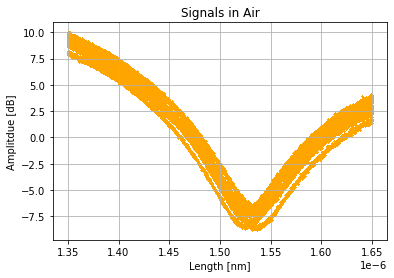

In [29]:
plt.scatter(df.iloc[:,0], df.iloc[:,1], s=0.1, c='orange')
plt.title("Signals in Air")
plt.xlabel("Length [nm]")
plt.ylabel("Amplitdue [dB]")
plt.grid()


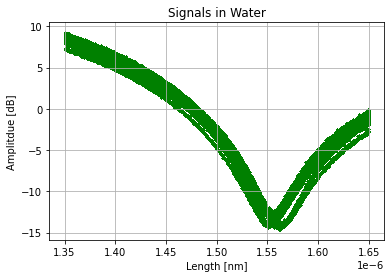

In [30]:
plt.scatter(df.iloc[:,0], df.iloc[:,2], s=0.1, c='g')
plt.title("Signals in Water")
plt.xlabel("Length [nm]")
plt.ylabel("Amplitdue [dB]")
plt.grid()

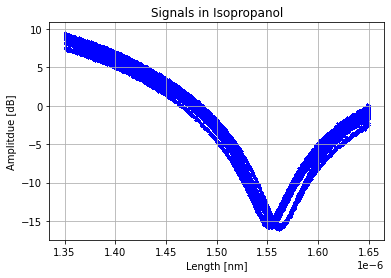

In [31]:
plt.scatter(df.iloc[:,0], df.iloc[:,3], s=0.1, c='b')
plt.title("Signals in Isopropanol")
plt.xlabel("Length [nm]")
plt.ylabel("Amplitdue [dB]")
plt.grid()

As we can see, our assumptions were not entirely correct. We see that the measurements between sensors differ from each other. We can consider this as the error margin. We will try to predict the two values of signals (water, isopropanol) based on the measurement data in water.

#### 4.Prepare the data to Machine Learning algorithms

In [32]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)

In [44]:
stats = {"mean": np.mean(df_scaled),
"median": np.median(df_scaled),
"min": np.amin(df_scaled),
"max": np.amax(df_scaled),
"range": np.ptp(df_scaled),
"std": np.std(df_scaled),}

stats = pd.DataFrame([stats])

In [47]:
stats

,mean,median,min,max,range,std
0,-2.53352e-16,1.11398e-02,-2.06506e+00,1.87681e+00,3.94187e+00,1.00000e+00


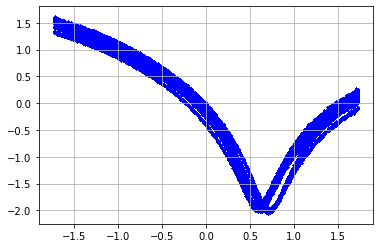

In [33]:
plt.scatter(df_scaled[:,0], df_scaled[:,3], s=0.1, c='b')
plt.grid()

In [49]:
X = df_scaled[:, :2]
y = df_scaled[:, 2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#### 5. Explore different models

For a performance measure we select a RMSE. It is a typical performance measure for regression problems.

##### Linear Regression

In [50]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
pred = lin_reg.predict(X_test)

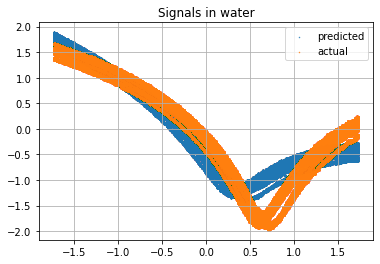

In [59]:
plt.scatter(X_test[:,0], pred[:,0], s=0.2, label='predicted')
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], s=0.2, label='actual')
plt.title("Signals in water")
plt.legend()
plt.grid()

In [56]:
lin_mse = mean_squared_error(y_test, pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.3777697339830189

#####  Polynomial Regression

In [84]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

poly = PolynomialFeatures(degree=2)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

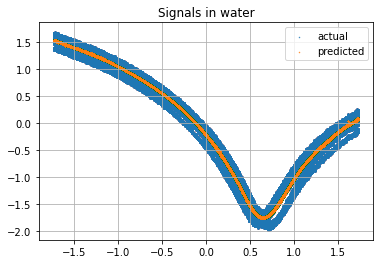

In [85]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], s=0.2, label='actual')
plt.scatter(X_test_trans[:,1], y_pred[:,0], s=0.2, label='predicted')
plt.title("Signals in water")
plt.legend()
plt.grid()

In [63]:
pol_mse = mean_squared_error(y_test, y_pred)
pol_rmse = np.sqrt(pol_mse)
pol_rmse

0.2150191493167676

Polynomial looks promising, lets check different degrees

In [73]:
def best_degree() -> dict:
    degrees = np.arange(1, 10)
    scores = {}
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_train_trans = poly.fit_transform(X_train)
        X_test_trans = poly.transform(X_test)

        lr = LinearRegression()
        lr.fit(X_train_trans, y_train)
        y_pred = lr.predict(X_test_trans)
        
        lin_reg_poly_mse = mean_squared_error(y_test, y_pred)
        lin_reg_poly_rmse = np.sqrt(lin_reg_poly_mse)
        scores.update({degree: lin_reg_poly_rmse})
    return scores

In [82]:
degrees = best_degree()
degrees

{1: 0.3777697339830178,
 2: 0.2150191493167676,
 3: 0.1537114607712496,
 4: 0.1415463558250382,
 5: 0.12689706627271768,
 6: 0.12327281835656795,
 7: 0.12233870863143094,
 8: 0.12151962413015044,
 9: 0.12139660573012052}

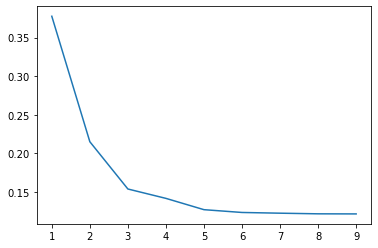

In [83]:
plt.plot(degrees.keys(), degrees.values())

It looks like there may be more degrees, for now let's stop at 9.

In [86]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

poly = PolynomialFeatures(degree=9)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

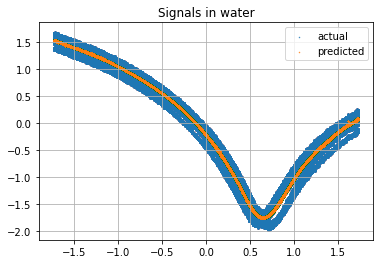

In [87]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], s=0.2, label='actual')
plt.scatter(X_test_trans[:,1], y_pred[:,0], s=0.2, label='predicted')
plt.title("Signals in water")
plt.legend()
plt.grid()

##### Decision Tree

In [88]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_test, y_test)
pred = tree_reg.predict(X_test)

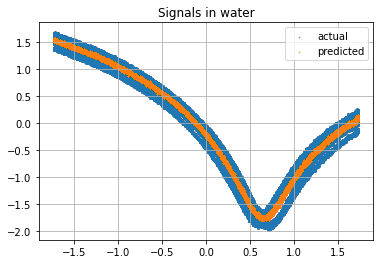

In [92]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], s=0.2, label='actual')
plt.scatter(X_test[:,0], pred[:,0], s=0.2, label='predicted')
plt.title("Signals in water")
plt.legend()
plt.grid()

In [93]:
pol_mse = mean_squared_error(y_test, pred)
pol_rmse = np.sqrt(pol_mse)
pol_rmse

0.11979778254640407

##### XGBRegressor

In [94]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
pred = xgb_reg.predict(X_test)

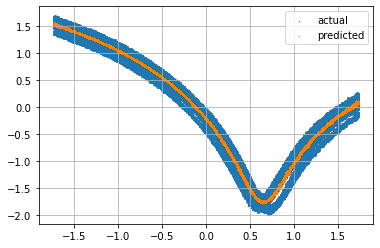

In [95]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 2], s=0.2, label='actual')
plt.scatter(X_test[:,0], pred[:,0], s=0.2, label='predicted')
plt.legend()
plt.grid()

In [96]:
xgb_mse = mean_squared_error(y_test, pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.12111634788241527

#### 6. Solution

All models indicate similar values, the second model slightly performs better. We will use it to determine the remaining values.

In [99]:
filename = "sensor_model.sav"
pickle.dump(tree_reg, open(filename, "wb"))

#### 7. Further exploration

The approach presented above is just the beginning. In the future, we can consider selecting other models or even neural networks. We can also use GridSearch to choose the best parameters for our model. Or we can use cross-validation for a better evaluation.